In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble as ske
import eli5
from eli5.sklearn import PermutationImportance
from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

Using TensorFlow backend.


In [257]:
df = pd.read_csv('mpr/Data/features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [259]:
print("Dataset has",df.shape)
df.label.value_counts().reset_index()

Dataset has (9990, 60)


index  label
0       jazz   1000
1      metal   1000
2        pop   1000
3     reggae   1000
4      blues   1000
5      disco    999
6       rock    998
7  classical    998
8     hiphop    998
9    country    997

In [4]:
audio_fp = 'mpr/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [5]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

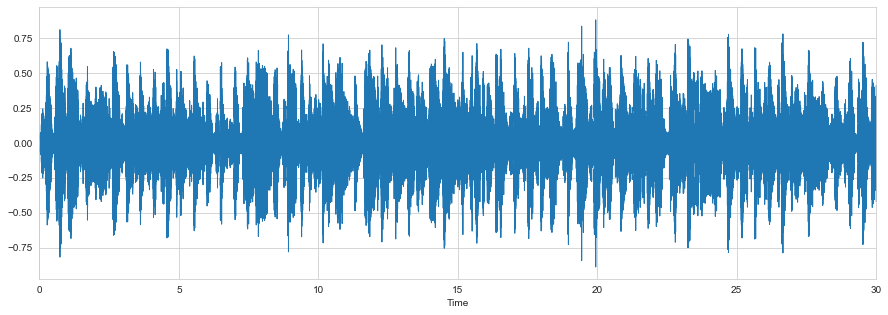

In [6]:
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()


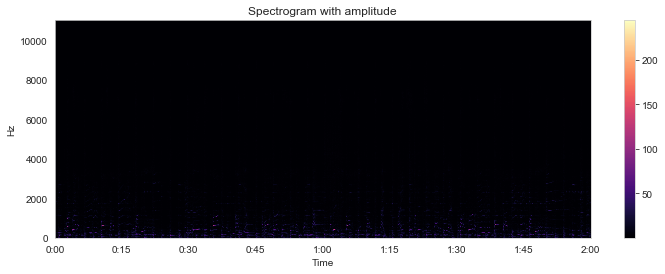

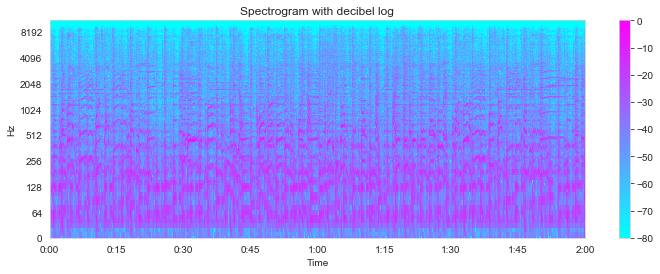

In [261]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

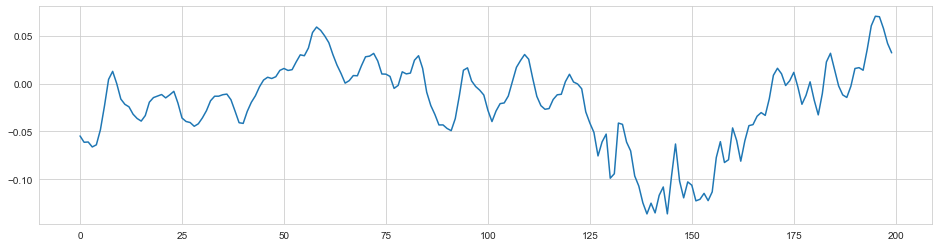

In [8]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

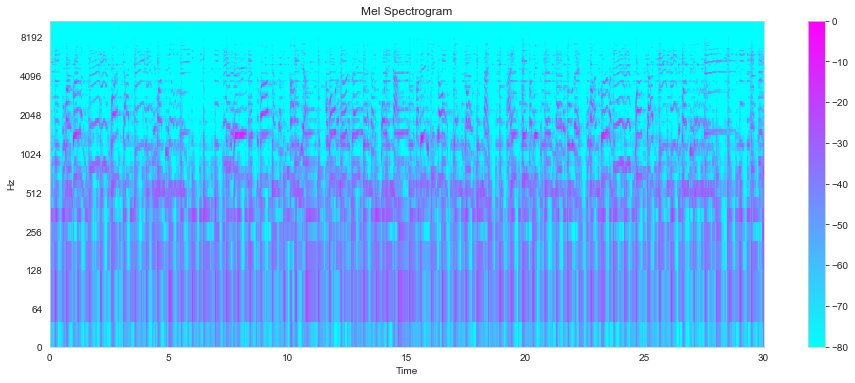

In [9]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

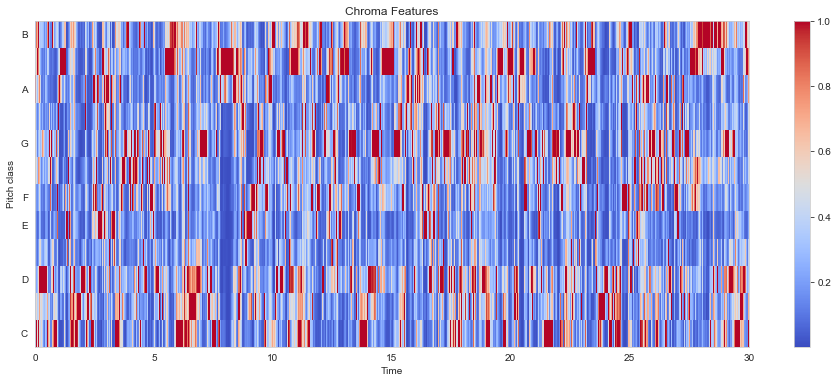

In [10]:
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

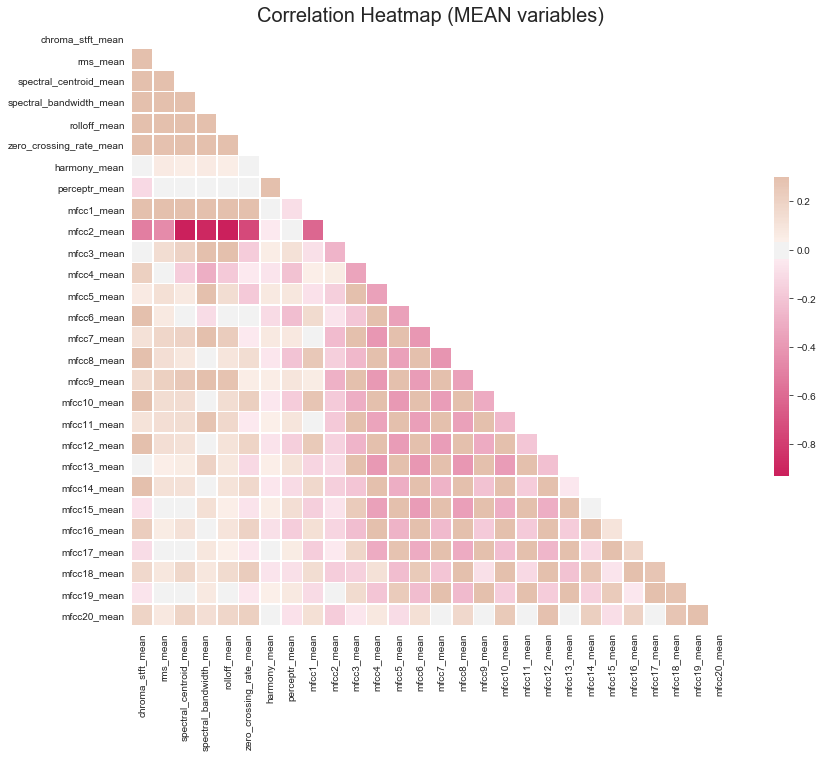

In [11]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr_Heatmap.png")

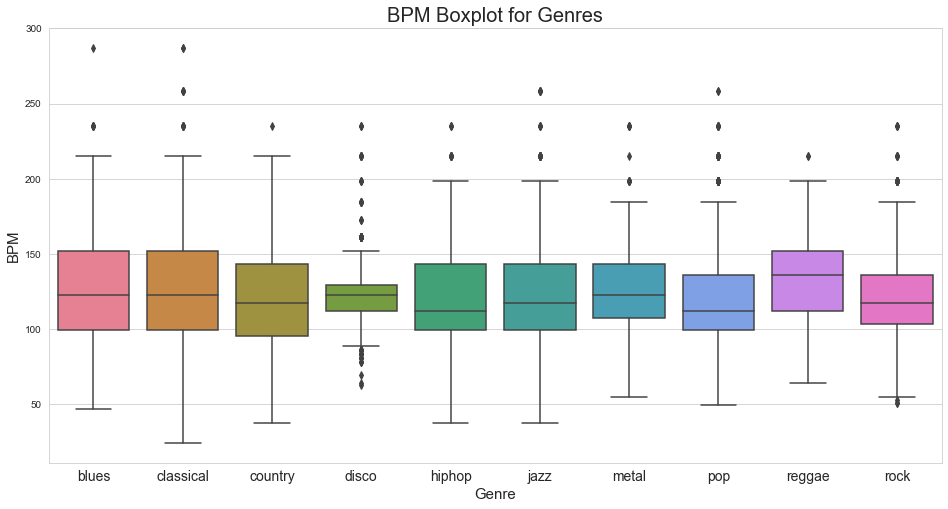

In [12]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

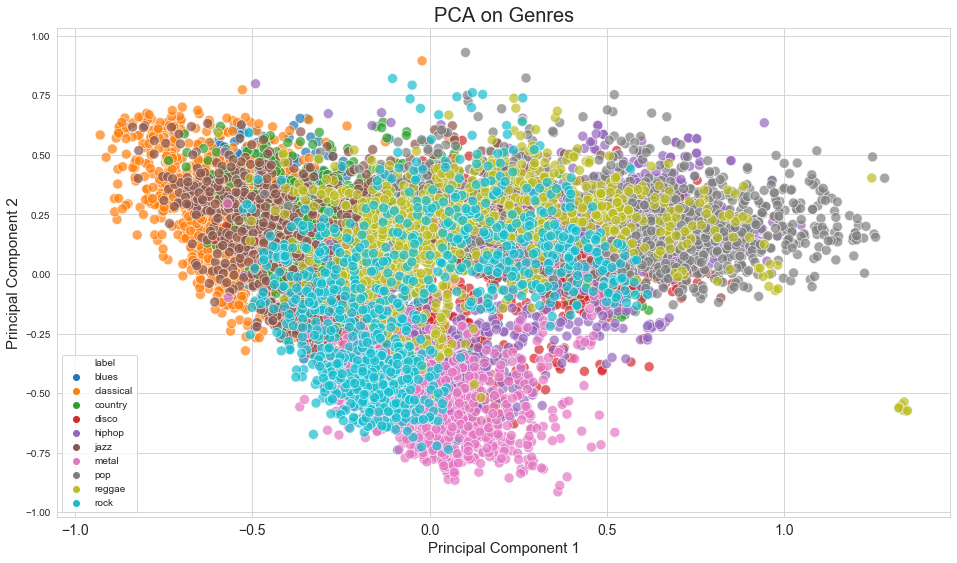

In [13]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

In [14]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


No null values in the dataset

There are no categorical variable as such. Hence, Dummy variable creation is not needed.

## Encode Genre Label¶


In [15]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [16]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

## Split Train Dev & Test Sets

In [17]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [18]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [19]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [20]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


## Scale the Features

In [21]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [22]:
def predictProba(clf, X, dev=False):
    y_true = y_train
    if dev:
        X = X_dev[X.columns]
        y_true = y_dev
    y_pred_proba_X = clf.predict_proba(X)
    y_pred_X = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6, 6))
    skm.plot_confusion_matrix(clf, X, y_true, display_labels=X.columns, cmap=plt.cm.Blues, xticks_rotation=90, ax=ax)
    plt.show()
    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print("=====================================================")

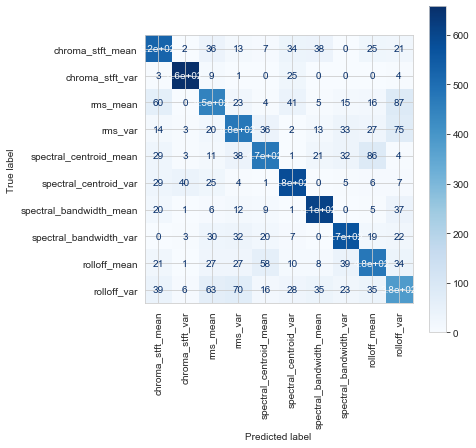

              precision    recall  f1-score   support

           0      0.709     0.749     0.728       700
           1      0.918     0.940     0.929       699
           2      0.663     0.640     0.652       698
           3      0.684     0.681     0.682       699
           4      0.758     0.678     0.716       699
           5      0.796     0.833     0.814       700
           6      0.835     0.870     0.852       700
           7      0.794     0.810     0.802       700
           8      0.684     0.679     0.681       700
           9      0.568     0.549     0.558       698

    accuracy                          0.743      6993
   macro avg      0.741     0.743     0.742      6993
weighted avg      0.741     0.743     0.742      6993



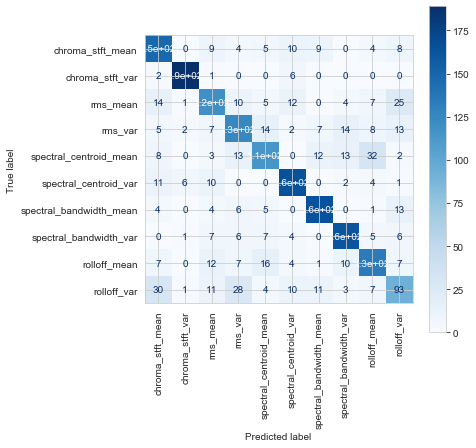

              precision    recall  f1-score   support

           0      0.648     0.753     0.696       198
           1      0.945     0.955     0.950       198
           2      0.650     0.604     0.626       197
           3      0.630     0.636     0.633       198
           4      0.671     0.579     0.621       197
           5      0.774     0.828     0.800       198
           6      0.805     0.833     0.819       198
           7      0.779     0.818     0.798       198
           8      0.663     0.677     0.670       198
           9      0.554     0.470     0.508       198

    accuracy                          0.715      1978
   macro avg      0.712     0.715     0.712      1978
weighted avg      0.712     0.715     0.712      1978



In [23]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_train,y_train)
predictProba(lr, X_train)
predictProba(lr, X_train, dev=True)

## Permutation Importance Feature Selection

In [24]:
perm = PermutationImportance(lr, random_state=seed).fit(X_train, y_train, n_iter=10)
print("Feature Importances using Permutation Importance")
eli5.show_weights(perm, feature_names = X_dev.columns.tolist())

Feature Importances using Permutation Importance


### Plot Permutation Importances

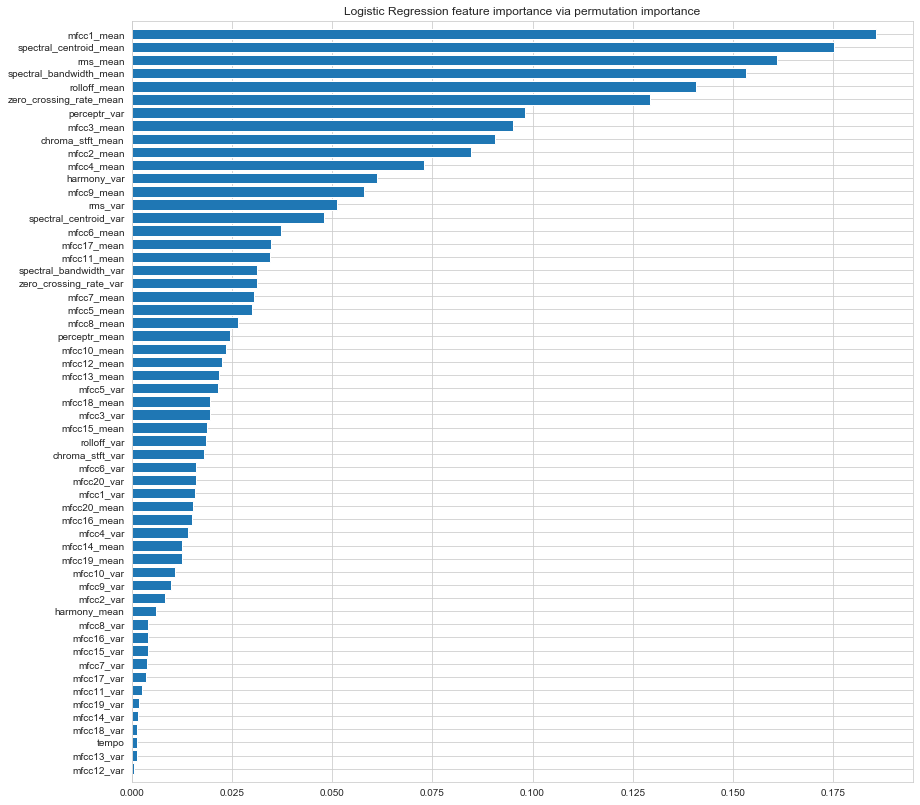

In [25]:
# plot the permutation importances
perm_indices = np.argsort(perm.feature_importances_)[::-1]
perm_features = [X_dev.columns.tolist()[xx] for xx in perm_indices]
plt.figure(figsize=(14, 14))
plt.title("Logistic Regression feature importance via permutation importance")
plt.barh(range(X_dev.shape[1]), perm.feature_importances_[perm_indices])
plt.yticks(range(X_dev.shape[1]), perm_features)
plt.ylim([X_dev.shape[1], -1])
plt.show()

### Model Score using Permutation Importances

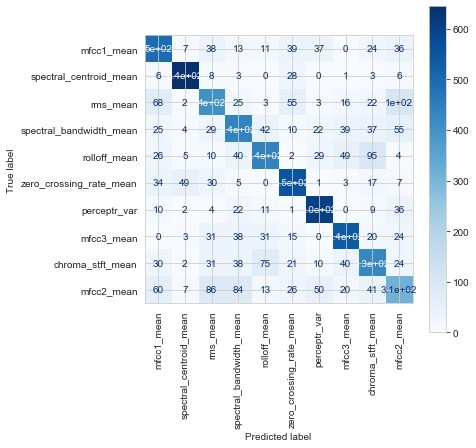

              precision    recall  f1-score   support

           0      0.656     0.707     0.681       700
           1      0.888     0.921     0.904       699
           2      0.601     0.577     0.589       698
           3      0.619     0.624     0.622       699
           4      0.702     0.628     0.663       699
           5      0.738     0.791     0.764       700
           6      0.799     0.864     0.830       700
           7      0.762     0.769     0.765       700
           8      0.615     0.613     0.614       700
           9      0.515     0.446     0.478       698

    accuracy                          0.694      6993
   macro avg      0.690     0.694     0.691      6993
weighted avg      0.690     0.694     0.691      6993



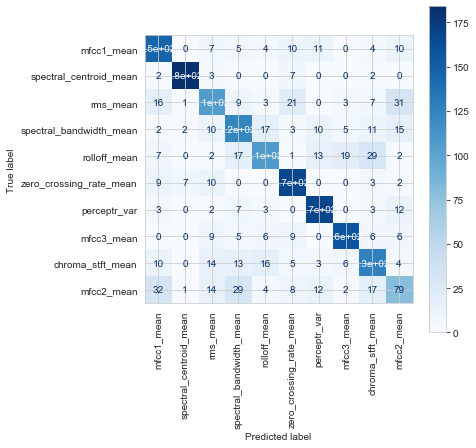

              precision    recall  f1-score   support

           0      0.645     0.742     0.690       198
           1      0.944     0.929     0.936       198
           2      0.599     0.538     0.567       197
           3      0.591     0.621     0.606       198
           4      0.669     0.543     0.599       197
           5      0.723     0.843     0.779       198
           6      0.774     0.848     0.810       198
           7      0.818     0.793     0.805       198
           8      0.608     0.641     0.624       198
           9      0.491     0.399     0.440       198

    accuracy                          0.690      1978
   macro avg      0.686     0.690     0.686      1978
weighted avg      0.686     0.690     0.686      1978



In [26]:
# build model using perm selected top 30 features
lr = LogisticRegression()
X_train_perm = X_train[perm_features[:30]]
X_train_rfe = X_train_perm
lr.fit(X_train_perm,y_train)
predictProba(lr, X_train_perm)
predictProba(lr, X_train_perm, dev=True)

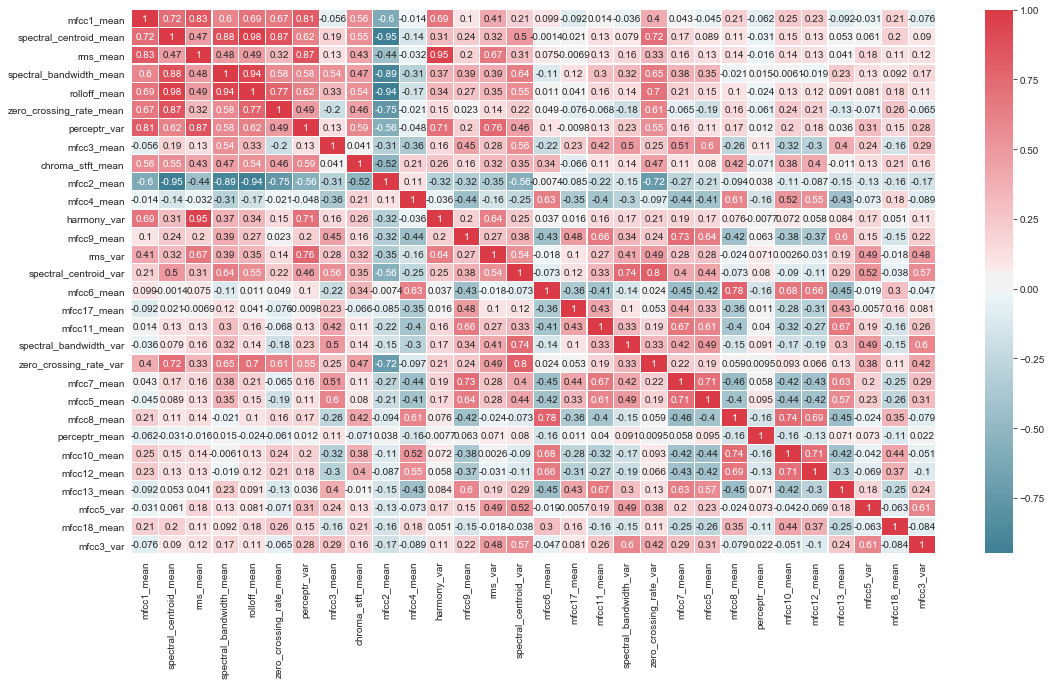

In [27]:
# plot correlation among top 30 selected featuers
plt.figure(figsize = (18, 10))
sns.heatmap(X_train_perm.corr(method='spearman'), annot = True, linewidths=.2, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()


## Model Building

### Logistic Regression

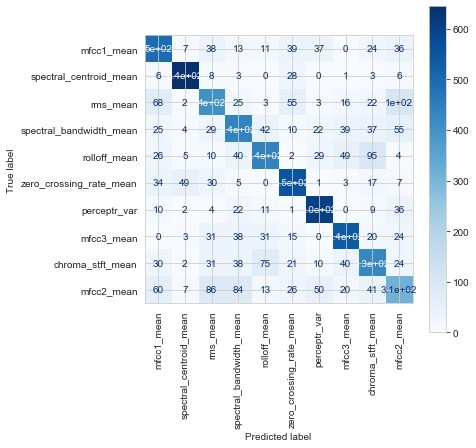

              precision    recall  f1-score   support

           0      0.656     0.707     0.681       700
           1      0.888     0.921     0.904       699
           2      0.601     0.577     0.589       698
           3      0.619     0.624     0.622       699
           4      0.702     0.628     0.663       699
           5      0.738     0.791     0.764       700
           6      0.799     0.864     0.830       700
           7      0.762     0.769     0.765       700
           8      0.615     0.613     0.614       700
           9      0.515     0.446     0.478       698

    accuracy                          0.694      6993
   macro avg      0.690     0.694     0.691      6993
weighted avg      0.690     0.694     0.691      6993



In [28]:
lr = LogisticRegression()
lr.fit(X_train_rfe,y_train)
predictProba(lr, X_train_rfe)

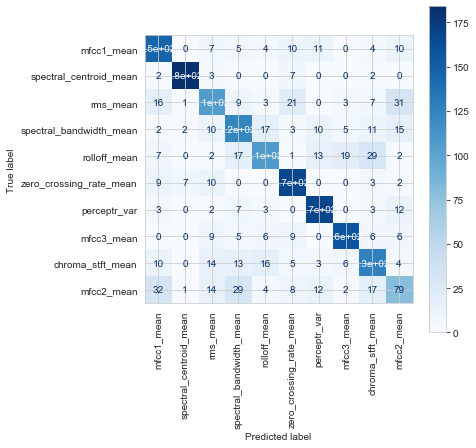

              precision    recall  f1-score   support

           0      0.645     0.742     0.690       198
           1      0.944     0.929     0.936       198
           2      0.599     0.538     0.567       197
           3      0.591     0.621     0.606       198
           4      0.669     0.543     0.599       197
           5      0.723     0.843     0.779       198
           6      0.774     0.848     0.810       198
           7      0.818     0.793     0.805       198
           8      0.608     0.641     0.624       198
           9      0.491     0.399     0.440       198

    accuracy                          0.690      1978
   macro avg      0.686     0.690     0.686      1978
weighted avg      0.686     0.690     0.686      1978



In [29]:
predictProba(lr, X_train_rfe, True)

### Random Forest

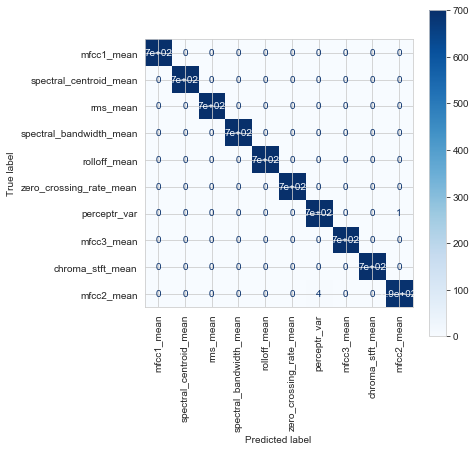

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.994     0.999     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.999     0.994     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [30]:
rfc = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rfc.fit(X_train_rfe, y_train)
predictProba(rfc, X_train_rfe)

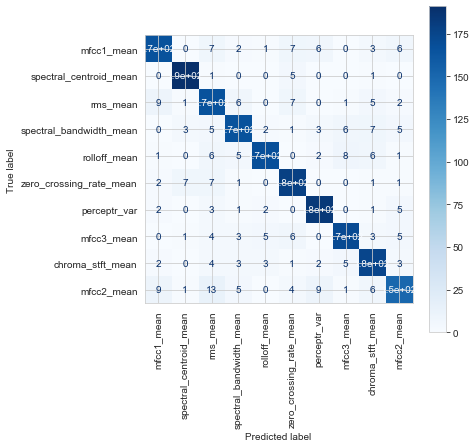

              precision    recall  f1-score   support

           0      0.869     0.838     0.853       198
           1      0.936     0.965     0.950       198
           2      0.769     0.843     0.804       197
           3      0.865     0.838     0.851       198
           4      0.928     0.853     0.889       197
           5      0.852     0.904     0.877       198
           6      0.893     0.929     0.911       198
           7      0.891     0.864     0.877       198
           8      0.841     0.884     0.862       198
           9      0.843     0.758     0.798       198

    accuracy                          0.868      1978
   macro avg      0.869     0.868     0.867      1978
weighted avg      0.869     0.868     0.867      1978



In [31]:
predictProba(rfc, X_train_rfe, True)

### AdaBoost

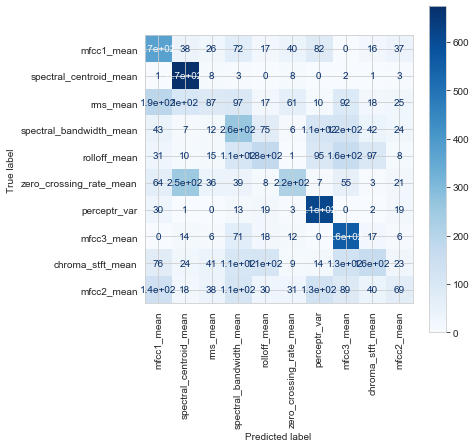

              precision    recall  f1-score   support

           0      0.394     0.531     0.453       700
           1      0.591     0.963     0.732       699
           2      0.323     0.125     0.180       698
           3      0.296     0.375     0.331       699
           4      0.372     0.250     0.299       699
           5      0.558     0.309     0.397       700
           6      0.577     0.876     0.695       700
           7      0.462     0.794     0.584       700
           8      0.407     0.231     0.295       700
           9      0.294     0.099     0.148       698

    accuracy                          0.455      6993
   macro avg      0.427     0.455     0.412      6993
weighted avg      0.428     0.455     0.412      6993



In [32]:
abc = ske.AdaBoostClassifier(n_estimators=100, random_state=seed)
abc.fit(X_train_rfe, y_train)
predictProba(abc, X_train_rfe)

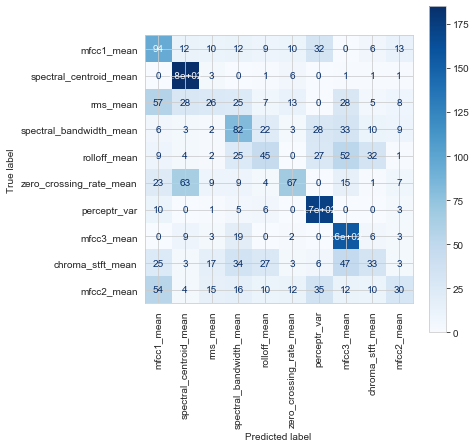

              precision    recall  f1-score   support

           0      0.338     0.475     0.395       198
           1      0.595     0.934     0.727       198
           2      0.295     0.132     0.182       197
           3      0.361     0.414     0.386       198
           4      0.344     0.228     0.274       197
           5      0.578     0.338     0.427       198
           6      0.575     0.874     0.693       198
           7      0.453     0.788     0.576       198
           8      0.317     0.167     0.219       198
           9      0.385     0.152     0.217       198

    accuracy                          0.450      1978
   macro avg      0.424     0.450     0.410      1978
weighted avg      0.424     0.450     0.410      1978



In [33]:
predictProba(abc, X_train_rfe, True)

### GBM

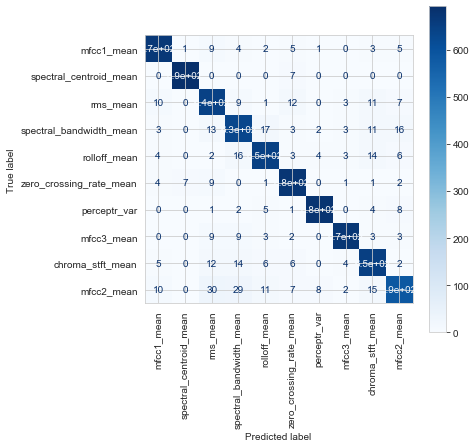

              precision    recall  f1-score   support

           0      0.949     0.957     0.953       700
           1      0.989     0.990     0.989       699
           2      0.884     0.924     0.903       698
           3      0.884     0.903     0.893       699
           4      0.934     0.926     0.930       699
           5      0.936     0.964     0.950       700
           6      0.978     0.970     0.974       700
           7      0.977     0.959     0.968       700
           8      0.913     0.930     0.921       700
           9      0.923     0.840     0.879       698

    accuracy                          0.936      6993
   macro avg      0.937     0.936     0.936      6993
weighted avg      0.937     0.936     0.936      6993



In [34]:
gbc = ske.GradientBoostingClassifier(n_estimators=100, random_state=seed)
gbc.fit(X_train_rfe, y_train)
predictProba(gbc, X_train_rfe)

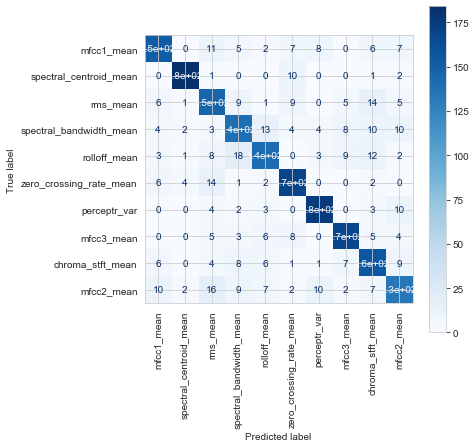

              precision    recall  f1-score   support

           0      0.813     0.768     0.790       198
           1      0.948     0.929     0.939       198
           2      0.690     0.746     0.717       197
           3      0.718     0.707     0.712       198
           4      0.779     0.716     0.746       197
           5      0.805     0.854     0.828       198
           6      0.871     0.889     0.880       198
           7      0.843     0.843     0.843       198
           8      0.722     0.788     0.754       198
           9      0.731     0.672     0.700       198

    accuracy                          0.791      1978
   macro avg      0.792     0.791     0.791      1978
weighted avg      0.792     0.791     0.791      1978



In [35]:
predictProba(gbc, X_train_rfe, True)

### XGBoost

In [36]:
import xgboost as xgb
print(xgb.__version__)


0.90


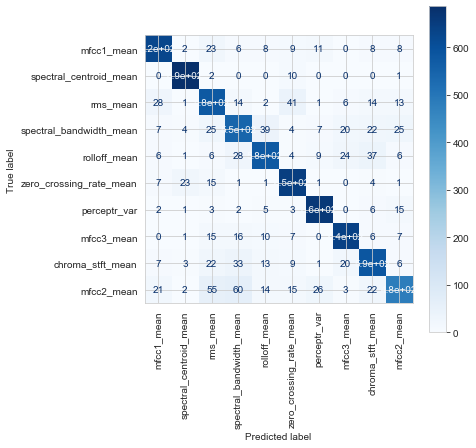

              precision    recall  f1-score   support

           0      0.889     0.893     0.891       700
           1      0.948     0.981     0.964       699
           2      0.777     0.828     0.802       698
           3      0.773     0.781     0.777       699
           4      0.863     0.827     0.844       699
           5      0.864     0.924     0.893       700
           6      0.922     0.947     0.934       700
           7      0.897     0.911     0.904       700
           8      0.831     0.837     0.834       700
           9      0.854     0.688     0.762       698

    accuracy                          0.862      6993
   macro avg      0.862     0.862     0.861      6993
weighted avg      0.862     0.862     0.861      6993



In [37]:
xgbc = xgb.XGBClassifier(n_estimators=100, random_state=seed)
xgbc.fit(X_train_rfe, y_train)
predictProba(xgbc, X_train_rfe)

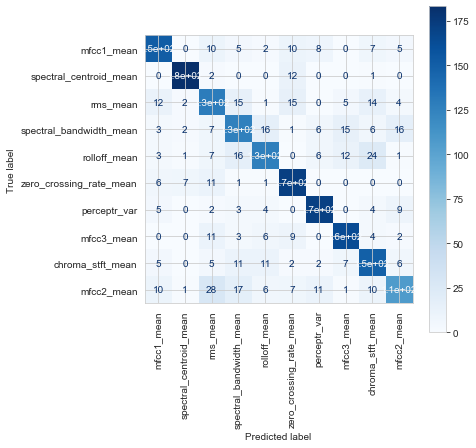

              precision    recall  f1-score   support

           0      0.774     0.763     0.768       198
           1      0.934     0.924     0.929       198
           2      0.608     0.655     0.631       197
           3      0.640     0.636     0.638       198
           4      0.730     0.645     0.685       197
           5      0.754     0.869     0.808       198
           6      0.838     0.864     0.851       198
           7      0.803     0.823     0.813       198
           8      0.680     0.753     0.715       198
           9      0.713     0.540     0.615       198

    accuracy                          0.747      1978
   macro avg      0.748     0.747     0.745      1978
weighted avg      0.748     0.747     0.745      1978



In [38]:
predictProba(xgbc, X_train_rfe, True)

### CatBoost

In [39]:
import catboost as cb
print(cb.__version__)

0.24.4


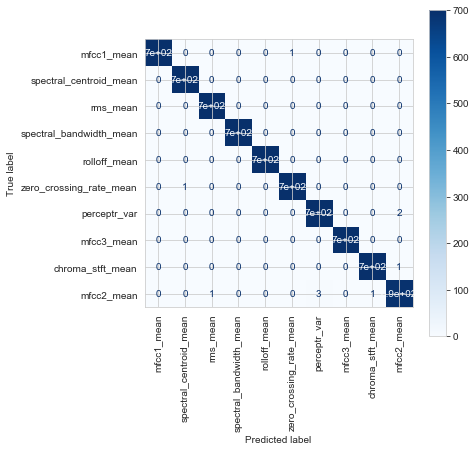

              precision    recall  f1-score   support

           0      1.000     0.999     0.999       700
           1      0.999     1.000     0.999       699
           2      0.999     1.000     0.999       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      0.999     0.999     0.999       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      0.999     0.999     0.999       700
           9      0.996     0.993     0.994       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [40]:
cbc = cb.CatBoostClassifier(random_state=seed, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(X_train_rfe, y_train)
predictProba(cbc, X_train_rfe)

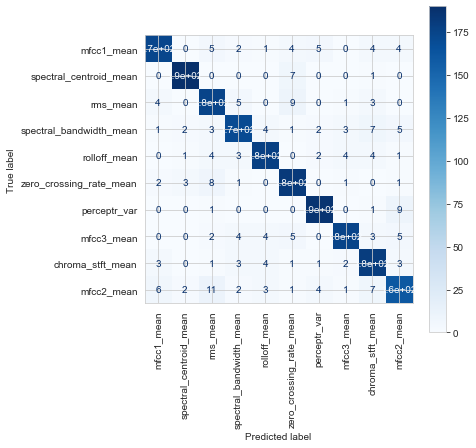

              precision    recall  f1-score   support

           0      0.915     0.874     0.894       198
           1      0.960     0.960     0.960       198
           2      0.833     0.888     0.860       197
           3      0.895     0.859     0.876       198
           4      0.918     0.904     0.910       197
           5      0.867     0.919     0.892       198
           6      0.930     0.944     0.937       198
           7      0.936     0.884     0.909       198
           8      0.857     0.909     0.882       198
           9      0.852     0.813     0.832       198

    accuracy                          0.895      1978
   macro avg      0.896     0.895     0.895      1978
weighted avg      0.896     0.895     0.895      1978



In [41]:
predictProba(cbc, X_train_rfe, True)

## Model Tuning

### RF Model HP Tuning


In [42]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 4)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 60, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)

{'max_depth': [1, 15, 30, 45, 60],
 'min_samples_split': [5, 10, 15],
 'n_estimators': [10, 140, 270, 400]}


In [43]:
# Use grid search to find best hyperparameters
rfc_n = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rf_random = skms.GridSearchCV(estimator = rfc_n, param_grid=random_grid, cv = 5, verbose=2, n_jobs = -1, scoring='f1_weighted')
# Fit the random search model
rf_random.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=12,
                                    

In [44]:
# best random model 
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)


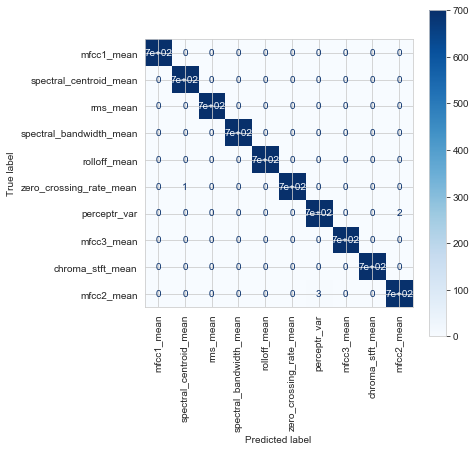

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      0.999     1.000     0.999       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     0.999     0.999       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [45]:
# Performance metrics
predictProba(rf_random.best_estimator_, X_train_rfe)

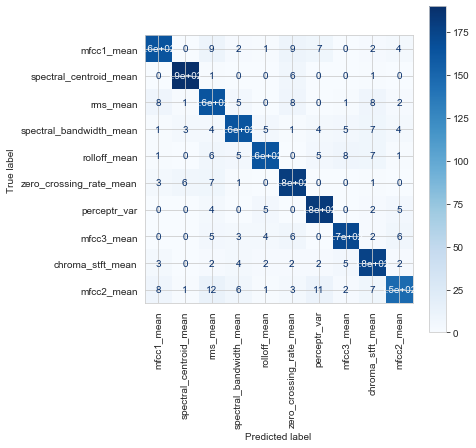

              precision    recall  f1-score   support

           0      0.872     0.828     0.850       198
           1      0.945     0.960     0.952       198
           2      0.766     0.832     0.798       197
           3      0.863     0.828     0.845       198
           4      0.901     0.832     0.865       197
           5      0.837     0.909     0.872       198
           6      0.863     0.919     0.890       198
           7      0.891     0.869     0.880       198
           8      0.826     0.889     0.856       198
           9      0.860     0.742     0.797       198

    accuracy                          0.861      1978
   macro avg      0.863     0.861     0.861      1978
weighted avg      0.863     0.861     0.861      1978



In [46]:
predictProba(rf_random.best_estimator_, X_train_rfe, True)

### XGB Model HP Tuning

In [47]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=seed)

xgb_params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

In [48]:
# Use the random grid to search for best hyperparameters
xgb_random = skms.RandomizedSearchCV(estimator = xgb_model, param_distributions=xgb_params, n_iter=20, cv = 3, verbose=2, n_jobs = -1, random_state=seed, scoring='f1_weighted', return_train_score=True)
# Fit the random search model
xgb_random.fit(X_train_rfe, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=12, reg_alpha=0,
                                           reg_lambda=1, s...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb78d9636d0>,
                                        'n_estimator

In [49]:
# best xgb_random model 
print(xgb_random.best_estimator_)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9066782998097372,
              gamma=0.0016439843761698048, learning_rate=0.3000310498970947,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
              n_estimators=137, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=12, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.6023637423473936, verbosity=1)


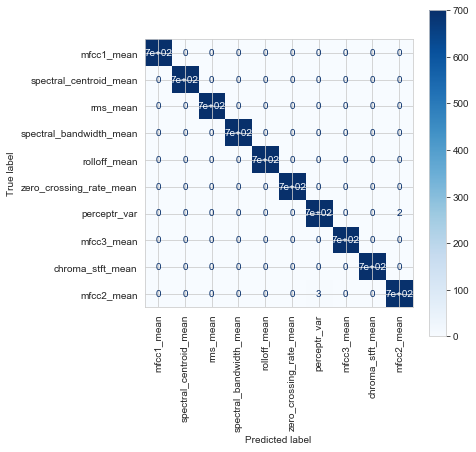

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [50]:
# Performance metrics
predictProba(xgb_random.best_estimator_, X_train_rfe)

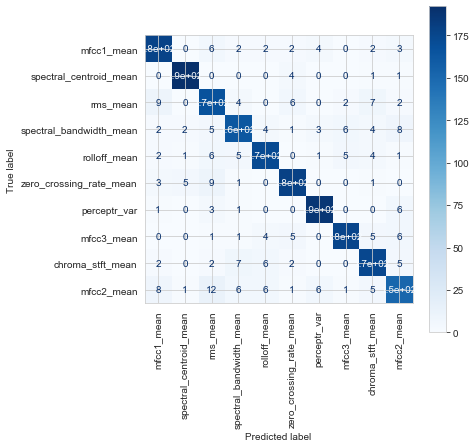

              precision    recall  f1-score   support

           0      0.868     0.894     0.881       198
           1      0.955     0.970     0.962       198
           2      0.791     0.848     0.819       197
           3      0.858     0.823     0.840       198
           4      0.887     0.873     0.880       197
           5      0.895     0.904     0.899       198
           6      0.930     0.944     0.937       198
           7      0.926     0.889     0.907       198
           8      0.857     0.879     0.868       198
           9      0.826     0.768     0.796       198

    accuracy                          0.879      1978
   macro avg      0.879     0.879     0.879      1978
weighted avg      0.879     0.879     0.879      1978



In [51]:
predictProba(xgb_random.best_estimator_, X_train_rfe, True)

## Model Evaluation

In [52]:
y_pred_X = rf_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("RF Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.837     0.853     0.845       102
           1      0.898     0.960     0.928       101
           2      0.780     0.765     0.772       102
           3      0.905     0.843     0.873       102
           4      0.876     0.833     0.854       102
           5      0.841     0.882     0.861       102
           6      0.900     0.971     0.934       102
           7      0.903     0.912     0.907       102
           8      0.829     0.853     0.841       102
           9      0.811     0.716     0.760       102

    accuracy                          0.859      1019
   macro avg      0.858     0.859     0.858      1019
weighted avg      0.858     0.859     0.858      1019

RF Test Accuracy - 85.8684985279686


In [53]:
y_pred_X = xgb_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("XGB Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.848     0.873     0.860       102
           1      0.917     0.980     0.947       101
           2      0.771     0.824     0.796       102
           3      0.878     0.843     0.860       102
           4      0.937     0.873     0.904       102
           5      0.850     0.833     0.842       102
           6      0.950     0.941     0.946       102
           7      0.931     0.922     0.926       102
           8      0.911     0.902     0.906       102
           9      0.822     0.814     0.818       102

    accuracy                          0.880      1019
   macro avg      0.881     0.880     0.880      1019
weighted avg      0.881     0.880     0.880      1019

XGB Test Accuracy - 88.02747791952895


In [54]:
y_pred_X = cbc.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("CatBoost Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.867     0.892     0.879       102
           1      0.926     0.990     0.957       101
           2      0.800     0.824     0.812       102
           3      0.918     0.882     0.900       102
           4      0.946     0.863     0.903       102
           5      0.891     0.882     0.887       102
           6      0.961     0.971     0.966       102
           7      0.942     0.951     0.946       102
           8      0.877     0.912     0.894       102
           9      0.835     0.794     0.814       102

    accuracy                          0.896      1019
   macro avg      0.896     0.896     0.896      1019
weighted avg      0.896     0.896     0.896      1019

CatBoost Test Accuracy - 89.59764474975465


Here, we had CatBoost as the best model among all ensemble techniques without any HP tuning on the same.

## CHECKING

In [56]:
X_train[:1]

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0         -1.062377         1.059887 -0.017604  0.292234   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                0.161324               2.043523                  0.52615   

   spectral_bandwidth_var  rolloff_mean  rolloff_var  ...  mfcc16_mean  \
0                 0.22409      0.175876     1.097624  ...    -0.558123   

   mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0   -0.705555     0.119994   -0.205566    -0.226063    0.149913     0.899041   

   mfcc19_var  mfcc20_mean  mfcc20_var  
0   -0.166056    -0.231108   -0.363293  

[1 rows x 57 columns]

0:blues---
1:pop---
2:jazz---
3:reggae---
4:metal---
5:disco---
6:classical---
7:hiphop---
8:rock---
9:country---

In [79]:
t = cbc.predict(X_train[211:212])
print(t)
if t== [[0]]:
    print('blues')
elif t== [[1]]:
    print('pop')
elif t== [[2]]:
    print('jazz')
elif t== [[3]]:
    print('reggae')
elif t== [[4]]:
    print('metal')
elif t== [[5]]:
    print('disco')
elif t== [[6]]:
    print('classical')
elif t== [[7]]:
    print('hiphop')
elif t== [[8]]:
    print('rock')
else:
    print('country')

[[8]]
rock


## KNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier as knn


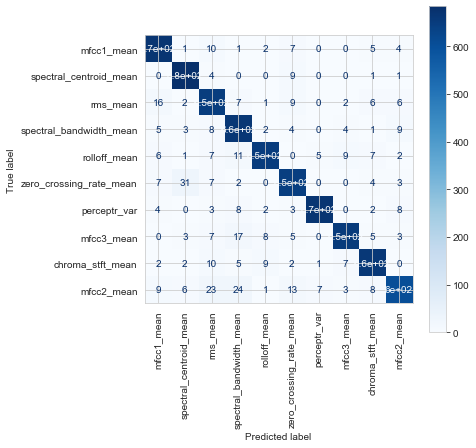

              precision    recall  f1-score   support

           0      0.932     0.957     0.944       700
           1      0.933     0.979     0.955       699
           2      0.891     0.930     0.910       698
           3      0.898     0.948     0.923       699
           4      0.963     0.931     0.947       699
           5      0.926     0.923     0.924       700
           6      0.981     0.957     0.969       700
           7      0.963     0.931     0.947       700
           8      0.944     0.946     0.945       700
           9      0.944     0.865     0.903       698

    accuracy                          0.937      6993
   macro avg      0.938     0.937     0.937      6993
weighted avg      0.938     0.937     0.937      6993



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [116]:
cls = knn()
cls2=knn()
cls.fit(X_train_rfe, y_train)
predictProba(cls, X_train_rfe)
cls2.fit(X_train, y_train)
#Y = cls.predict(X_train_rfe)
#print(y)

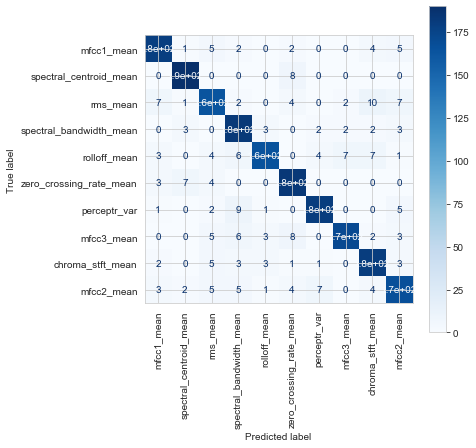

              precision    recall  f1-score   support

           0      0.904     0.904     0.904       198
           1      0.931     0.960     0.945       198
           2      0.845     0.832     0.839       197
           3      0.847     0.924     0.884       198
           4      0.938     0.838     0.885       197
           5      0.872     0.929     0.900       198
           6      0.928     0.909     0.918       198
           7      0.940     0.864     0.900       198
           8      0.861     0.909     0.885       198
           9      0.861     0.843     0.852       198

    accuracy                          0.891      1978
   macro avg      0.893     0.891     0.891      1978
weighted avg      0.893     0.891     0.891      1978



In [71]:
predictProba(cls, X_train_rfe, True)

In [123]:
y_pred_X = cls.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("KNN Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.931     0.922     0.926       102
           1      0.874     0.960     0.915       101
           2      0.850     0.833     0.842       102
           3      0.885     0.902     0.893       102
           4      0.944     0.824     0.880       102
           5      0.893     0.902     0.898       102
           6      0.943     0.971     0.957       102
           7      0.904     0.922     0.913       102
           8      0.889     0.941     0.914       102
           9      0.894     0.824     0.857       102

    accuracy                          0.900      1019
   macro avg      0.901     0.900     0.899      1019
weighted avg      0.901     0.900     0.899      1019

KNN Test Accuracy - 89.9901864573111


In [128]:
##PURELY FOR TESTING






#cls.predict(X_train_rfe)
#cbc.predict(X_train_rfe)


#X_train[211:212]
#cbc.predict(X_train[211:212])
#cls.predict(X_train[211:212])

print(X_train.shape)
print(X_train_rfe.shape)
print(X_test.shape)

y_train.shape

print(cls.predict(X_train_rfe[211:215]),cbc.predict(X_train_rfe[211:215]))




#######

(6993, 57)
(6993, 30)
(1019, 57)
[8 0 1 8] [[8]
 [0]
 [1]
 [8]]


In [154]:
if X_train_rfe[112:113]['mfcc1_mean'] in X_train['mfcc1_mean']:
    print(True)
else:
    print(False)
#audio_fp = 'mpr/Data/genres_original/blues/blues.00000.wav'
#audio_data, sr = librosa.load(audio_fp)
#audio_data, _ = librosa.effects.trim(audio_data)

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [248]:
kkk = X_train_rfe[112:113]['mfcc1_mean']
kkk
kkq = [t for t in X_train['mfcc1_mean']]
kkq
#tk = False
#if (X_train_rfe[112:113]['mfcc1_mean']) in kkq:
#tk= True
#if tk==True:
#print(X_train_rfe[112:113]['mfcc1_mean'])
for i in kkq:
    ri = round(i,6)
    #print(ri)
    if i == float(X_train_rfe[112:113]['mfcc1_mean']):
        print(i)
    #else:
       # print('no lol')
#if float(X_train_rfe[112:113]['mfcc1_mean']) in kkq2:
 #   print('lol')

0.46548872040597944


In [242]:
for i in X_train:
    if float(i['mfcc1_mean']) == float(X_train_rfe[112:113]['mfcc1_mean']):
        print(i)

TypeError: string indices must be integers

In [253]:
#for i in X_train[:][]:
#    print(i)
df['mfcc1_mean']

0      -118.627914
1      -125.590706
2      -132.441940
3      -118.231087
4      -105.968376
           ...    
9985   -224.972168
9986   -192.806641
9987   -287.840088
9988   -162.659592
9989   -236.018494
Name: mfcc1_mean, Length: 9990, dtype: float64

In [247]:
for i in df:
    print(i)

filename
length
chroma_stft_mean
chroma_stft_var
rms_mean
rms_var
spectral_centroid_mean
spectral_centroid_var
spectral_bandwidth_mean
spectral_bandwidth_var
rolloff_mean
rolloff_var
zero_crossing_rate_mean
zero_crossing_rate_var
harmony_mean
harmony_var
perceptr_mean
perceptr_var
tempo
mfcc1_mean
mfcc1_var
mfcc2_mean
mfcc2_var
mfcc3_mean
mfcc3_var
mfcc4_mean
mfcc4_var
mfcc5_mean
mfcc5_var
mfcc6_mean
mfcc6_var
mfcc7_mean
mfcc7_var
mfcc8_mean
mfcc8_var
mfcc9_mean
mfcc9_var
mfcc10_mean
mfcc10_var
mfcc11_mean
mfcc11_var
mfcc12_mean
mfcc12_var
mfcc13_mean
mfcc13_var
mfcc14_mean
mfcc14_var
mfcc15_mean
mfcc15_var
mfcc16_mean
mfcc16_var
mfcc17_mean
mfcc17_var
mfcc18_mean
mfcc18_var
mfcc19_mean
mfcc19_var
mfcc20_mean
mfcc20_var
label
